In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss

import cooper
import style_utils

torch.manual_seed(0)
np.random.seed(0)

# Mixture of Gaussians

This example is inspired by Fig. 2 in Cotter et al. (2019)

In [24]:
# Generate dataset
n_per_class = 100
dim = 2
n_gaussians = 4
mus = [(0, 1), (-1, 0), (0, -1), (1, 0)]
mus = [torch.tensor(m) for m in mus]
var = 0.05

inputs, labels = [], []

for id in range(n_gaussians):
    # Generate input data by mu + x @ sqrt(cov)
    cov = np.sqrt(var) * torch.eye(dim)
    mu = mus[id]
    inputs.append(mu + torch.randn(n_per_class, dim) @ cov)

    # Labels
    labels.append(torch.tensor(n_per_class * [1 if id < 2 else 0]))

inputs = torch.cat(inputs, dim=0)
labels = torch.cat(labels, dim=0)

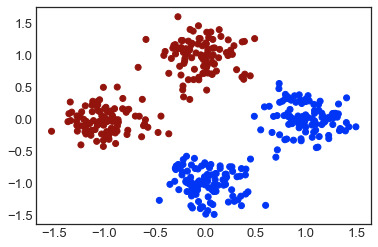

In [25]:
red, blue = style_utils.COLOR_DICT['red'], style_utils.COLOR_DICT['blue']
colors = [red if l == 1 else blue for l in labels.flatten()]

plt.scatter(*torch.transpose(inputs, 0, 1), color=colors)

In [ ]:
class MixtureSeparation(cooper.ConstrainedMinimizationProblem):
    def __init__(self, is_constrained, use_proxy=False):

        super().__init__(is_constrained=is_constrained)

        self.use_proxy = use_proxy

        # Linear predictor
        self.linear = torch.nn.Linear(2, 1)

    def closure(self, inputs, targets):

        logits = self.linear(inputs)
        loss=bce_loss(logits, targets),

        if not self.is_constrained:
            # Unconstrained problem of separating two classes
            state = cooper.CMPState(
                loss=loss,
            )

        if self.is_constrained:
            # Separating classes s.t. predicting at least 55% as class 0 (blue)

            probs = torch.sigmoid(logits)
            # Hinge approximation of the rate

            if not self.use_proxy:
                # Use a proxy for the constraint: a hinge relaxation
                state = cooper.CMPState(
                    loss=loss,
                    ineq_defect=_,
                )
            else:
                # Use non-proxy constraint defects to update the Lagrange multipliers

                # Proportion of elements in class 0 is the non-proxy defect
                classes = torch.round(probs)
                prop_0 = torch.sum(classes == 0) / targets.numel()

                state = cooper.CMPState(
                    loss=loss,
                    ineq_defect=_,
                    proxy_defect=0.55 - prop_0, # 55% - prop_0 <= 0
                )

        return state


## References

- A. Cotter, H. Jiang, M. Gupta, S. Wang, T. Narayan, S. You,
and K. Sridharan. Optimization with Non-Differentiable
Constraints with Applications to Fairness, Recall, Churn,
and Other Goals. In JMLR, 2019.